# 1. Import libraries

In [50]:
import numpy as np
import pandas as pd
import requests
from io import StringIO
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt

import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# 2. Load data

In [2]:
# Define url path to CSV
annex1 = 'https://raw.githubusercontent.com/prattapong/Data-Science-Portfolio/main/Projects/Supermaket%20Sales%20Data/data/annex1.csv'
annex2 = 'https://raw.githubusercontent.com/prattapong/Data-Science-Portfolio/main/Projects/Supermaket%20Sales%20Data/data/annex2.csv'
annex3 = 'https://raw.githubusercontent.com/prattapong/Data-Science-Portfolio/main/Projects/Supermaket%20Sales%20Data/data/annex3.csv'
annex4 = 'https://raw.githubusercontent.com/prattapong/Data-Science-Portfolio/main/Projects/Supermaket%20Sales%20Data/data/annex4.csv'

In [3]:
def get_df_from_url(url):
    # Create request response
    response = requests.get(url)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        # Create a file-like object from the raw content
        csv_content = StringIO(response.text)

        # Read the CSV file into a DataFrame
        df = pd.read_csv(csv_content)

        # Return DataFrame
        return df
    else:
        print(f"Failed to fetch data. Status code: {response.status_code}")

df_item = get_df_from_url(annex1)
df_transaction = get_df_from_url(annex2)
df_wholesale = get_df_from_url(annex3)
df_loss = get_df_from_url(annex4)

# 3. Merge and aggregate data

In [4]:
def merge_all_df(df_transaction: pd.DataFrame = df_transaction,
                 df_item: pd.DataFrame = df_item,
                 df_wholesale: pd.DataFrame = df_wholesale,
                 df_loss: pd.DataFrame = df_loss):

    df_merge = df_transaction.merge(df_item,
                                    how = 'left',
                                    on = 'Item Code')
    df_merge = df_merge.merge(df_wholesale,
                            how = 'left',
                            on = ['Date', 'Item Code'])
    df_merge = df_merge.merge(df_loss.drop('Item Name', axis = 1),
                            how = 'left',
                            on = 'Item Code')
    
    return df_merge

df_merge = merge_all_df()

In [5]:
# Create Sales column
df_merge['Sales'] = df_merge['Unit Selling Price (RMB/kg)'] * df_merge['Quantity Sold (kilo)']

# Aggregate as new table
df_agg = df_merge.groupby(['Date', 'Category Code', 'Item Code'], as_index = False)['Sales'].sum()
df_agg.head()

,Date,Category Code,Item Code,Sales
0,2020-07-01,1011010101,102900005115762,41.046
1,2020-07-01,1011010101,102900005115779,335.728
2,2020-07-01,1011010101,102900005115786,68.112
3,2020-07-01,1011010101,102900005115793,68.608
4,2020-07-01,1011010101,102900005115823,114.760


# 4. Feature Engineering

In [6]:
def create_date_feature(df: pd.DataFrame,
                       date_column: str):
    # Convert the 'Date' column to datetime type
    df['Date'] = pd.to_datetime(df['Date'])

    # Extract date components
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['DayOfWeek'] = df['Date'].dt.dayofweek  # Monday is 0 and Sunday is 6
    df['WeekNumber'] = df['Date'].dt.isocalendar().week
    df['Quarter'] = df['Date'].dt.quarter
    
    return df

df_agg = create_date_feature(df = df_agg,
                             date_column = 'Date')

# 5. Data Preprocessing

## 5.1 Change dtype

In [7]:
def reduce_memory_usage(df: pd.DataFrame,
                        categorical_columns: list = None):
    start_memory = df.memory_usage().sum() / 1024**2

    # Handle categorical columns
    if categorical_columns is not None:
        for col in categorical_columns:
            df[col] = df[col].astype('category')
    else:
        pass
    
    for col in df.columns:
        #  handle numerical features
        if df[col].dtype.name != 'object' and df[col].dtype.name != 'category':
            num_min = df[col].min()
            num_max = df[col].max()
        
            # minimize int dtype bytes
            if 'int' in df[col].dtype.name:
                if num_min > np.iinfo(np.int8).min and num_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype('int8')
                elif num_min > np.iinfo(np.int16).min and num_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype('int16')
                elif num_min > np.iinfo(np.int32).min and num_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype('int32')
                else:
                    df[col] = df[col].astype('int64')
                    
            # minimize float dtype bytes
            elif 'float' in df[col].dtype.name:
                if num_min > np.finfo(np.float16).min and num_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype('float16')
                elif num_min > np.finfo(np.float32).min and num_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype('float32')
                else:
                    df[col] = df[col].astype('float64')
        
        # handle object columns
        else:
            df[col] = df[col].astype('category')

    end_memory = df.memory_usage().sum() / 1024**2
    print('Start Memory: {:.2f} MB\nEnd Memory: {:.2f} MB'.format(start_memory, end_memory))
    return df

In [8]:
categorical_columns = ['Category Code', 'Item Code']
df_agg = reduce_memory_usage(df = df_agg,
                             categorical_columns = categorical_columns)
df_agg.dtypes

Start Memory: 2.53 MB
End Memory: 1.08 MB


Date             datetime64[ns]
Category Code          category
Item Code              category
Sales                   float16
Year                      int16
Month                      int8
Day                        int8
DayOfWeek                  int8
WeekNumber               UInt32
Quarter                    int8
dtype: object

## 5.2 Split train and test data

In [9]:
def create_split_date(df: pd.DataFrame,
                      date_column: str,
                      train_size: float):
    # Get max and min date of the dataset
    try:
        max_date, min_date = dt.strptime(df[date_column].max(), '%Y-%m-%d'), dt.strptime(df[date_column].min(), '%Y-%m-%d')
    except:
        max_date, min_date = df[date_column].max(), df[date_column].min()

    # Calculate 80% of the date range for splitting
    date_difference = max_date - min_date
    train_split = (min_date + train_size * date_difference).date()
    
    return train_split

def split_train_test_date(df: pd.DataFrame, split_date):
    """
    Split train and test data based on date
    """

    """ Args:
    df: DataFrame to split
    split_date: Date to split between train and test data
    """

    """ Return:
    train, test: pd.DataFrame
    """
    
    # Split train and test
    train = df[df['Date'].dt.date <= split_date]
    train = train.drop('Date', axis = 1)
    test = df[df['Date'].dt.date > split_date]
    test = test.drop('Date', axis = 1)

    print(f'Train size: {train.shape[0]} | {(100 * train.shape[0]/df.shape[0]):.2f}%')
    print(f'Test size: {test.shape[0]} | {(100 * test.shape[0]/df.shape[0]):.2f}%')

    return train, test


# 6. Train and evaluate

## 6.1 Train

In [55]:
def category_train_loop(df: pd.DataFrame, 
                        categories: list, 
                        xgb_model,
                        scaler = None,
                        include_item: bool = False):
    """
    Loop all category and train in each model separatelly
    """

    test_all = pd.DataFrame()
    y_pred_all = []
    for category in categories:
        print(f'Catgory Trainig: {category}')

        # Slice DataFrame to each category
        df_category = df[df['Category Code'] == category]

        # Aggregate
        if include_item == True:
            df_category = df_category.groupby(['Date', 'Item Code', 'Category Code'], as_index = False)['Sales'].sum()
        elif include_item == False:
            df_category = df_category.groupby(['Date', 'Category Code'], as_index = False)['Sales'].sum()

        # Create date feature
        df_category = create_date_feature(df = df_category,
                                          date_column = 'Date')

        # Split train and test
        train_split = create_split_date(df = df,
                                        date_column = 'Date',
                                        train_size = 0.8)
        train, test = split_train_test_date(df = df_category,
                                            split_date = train_split)

        # Create X and y to train and test
        X_train, y_train = train.drop('Sales', axis = 1), train[['Sales']]
        X_test, y_test = test.drop('Sales', axis = 1), test[['Sales']]

        # Scale data
        if scaler:
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
        else:
            pass

        ### Training
        print(f'Training...')
        xgb_model.fit(X = X_train,
                      y = y_train,
                      eval_set = [(X_train, y_train), (X_test, y_test)],
                      verbose = 100)
        print('--------------------------------------------\n')

        ### Predict
        y_pred = xgb_model.predict(X_test)

        # Append data to all data
        test_all = pd.concat([test_all, test], axis = 0)
        y_pred_all = np.concatenate((y_pred_all, y_pred))

    return test_all, y_pred_all

def plot_prediction(df_test: pd.DataFrame,
                    y_pred):
    
    # Merge prediction to test data
    df_predict = df_test.reset_index().merge(pd.DataFrame(data = y_pred, columns = ['prediction']),
                                             how = 'left',
                                             left_index = True,
                                             right_index = True)
    df_predict['Date'] = pd.to_datetime(df_predict[['Year', 'Month', 'Day']])

    # Aggregate to Category level
    df_predict_agg = df_predict.groupby(['Date','Category Code'], as_index = False)[['Sales','prediction']].sum()

    # Calculate RMSE in Category level
    rmse = np.sqrt(mean_squared_error(y_true = df_predict_agg['Sales'],
                                        y_pred = df_predict_agg['prediction']))
    print(f'RMSE: {rmse:.2f}')

    # Plot prediction
    plt.figure(figsize = (10,5))
    sns.lineplot(data = df_predict.groupby('Date')['Sales'].sum(), label = 'True label')
    sns.lineplot(data = df_predict.groupby('Date')['prediction'].sum(), label = 'Prediction')
    plt.show()
    

In [56]:
categories = df_agg['Category Code'].unique()
scaler = StandardScaler()
xgb_reg = xgb.XGBRegressor(n_estimators = 5000,
                            eval_metrics = mean_squared_error,
                            enable_categorical = True,
                            early_stopping_rounds = 200,
                            learning_rate = 0.001,
                            random_state = 244)

df_test, y_pred = category_train_loop(categories = categories,
                                      df = df_agg,
                                      xgb_model = xgb_reg,
                                      scaler = scaler,
                                      include_item = False)

Catgory Trainig: 1011010101
Train size: 5226 | 80.28%
Test size: 1284 | 19.72%
Training...
[0]	validation_0-rmse:424.76490	validation_1-rmse:380.37386
[100]	validation_0-rmse:388.23471	validation_1-rmse:358.27634
[200]	validation_0-rmse:355.32474	validation_1-rmse:338.75068
[300]	validation_0-rmse:325.71265	validation_1-rmse:321.72583
[400]	validation_0-rmse:299.11556	validation_1-rmse:306.68941
[500]	validation_0-rmse:275.13271	validation_1-rmse:293.47784
[600]	validation_0-rmse:253.63954	validation_1-rmse:281.86733
[700]	validation_0-rmse:234.41088	validation_1-rmse:271.32397
[800]	validation_0-rmse:217.25281	validation_1-rmse:261.90554
[900]	validation_0-rmse:201.92963	validation_1-rmse:253.54372
[1000]	validation_0-rmse:188.29081	validation_1-rmse:246.23517
[1100]	validation_0-rmse:176.16546	validation_1-rmse:239.66047
[1200]	validation_0-rmse:165.45408	validation_1-rmse:233.77629
[1300]	validation_0-rmse:155.98370	validation_1-rmse:228.08999
[1400]	validation_0-rmse:147.66073	vali

# 7. Results

RMSE: 368.38


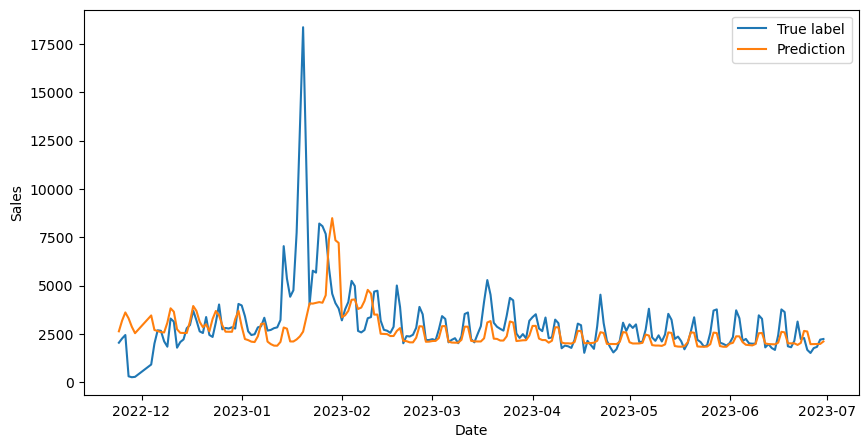

In [59]:
plot_prediction(df_test = df_test,
                y_pred = y_pred)

In [60]:
df_predict = df_test.reset_index().merge(pd.DataFrame(data = y_pred, columns = ['prediction']),
                                             how = 'left',
                                             left_index = True,
                                             right_index = True)
df_predict['Abs Error'] = abs(df_predict['Sales'] - df_predict['prediction'])
df_predict.sort_values(by = 'Abs Error', ascending = False).head()

,index,Category Code,Sales,Year,Month,Day,DayOfWeek,WeekNumber,Quarter,prediction,Abs Error
5452,5548,1011010504,6036.382812,2023,1,20,4,3,1,443.517487,5592.865326
5446,5542,1011010504,4398.406250,2023,1,19,3,3,1,443.517487,3954.888763
6737,5549,1011010801,3731.937500,2023,1,20,4,3,1,488.810608,3243.126892
318,5544,1011010101,3911.250000,2023,1,20,4,3,1,672.624939,3238.625061
6731,5543,1011010801,3173.509766,2023,1,19,3,3,1,443.824799,2729.684967
